In [50]:
import numpy as np
import math
import pylab as pl
from tqdm import tqdm
import matplotlib.font_manager as fm
import res_utils as ru
import copy

**Path integration for pattern sequences**

In [52]:
# moduli parameters
moduli = [3, 5]
n_mods = len(moduli)
N = 10000  # hyper dimension
Mprod = np.prod(moduli)

# noise parameter
kappa = 0.1
var = 0.1

# initialize the result lists
all_est = []
error = []

# generate the random codebook vectors
codebooks = []

# resonator parameters
num_iters = 20

xvs = []
count = 0
for c in range(2):
    for m, mod in enumerate(moduli):
        codebooks.append(np.zeros((mod, N), dtype='complex'))
        xv = ru.cvecl(N, loopsize=mod)
        # [x1,x2,y1,y2]  for 2 moduli 
        xvs.append(xv)
        for i in range(moduli[m]):
            codebooks[count][i, :] = xv**i
        count += 1

In [57]:
resonator = np.ones((n_mods*2, N), dtype=complex)
num_iters = 20
n_trials = 5
sequence_length = 30
vars = [0,0.05,0.06]

sequence_length = 30
accs = np.zeros((len(vars), n_trials, sequence_length))
sims = np.zeros((len(vars), n_trials, sequence_length))
sims_vec = np.zeros((len(vars), n_trials, sequence_length))

for nvar, var in enumerate(vars):
    for n_trial in tqdm(range(n_trials)):
        #generate a trajectory
        position = np.zeros((sequence_length, 2))
        for i in range(sequence_length-1):
            position[i+1] = position[i]
            index_to_modify = np.random.randint(0, 2)
            if position[i+1, index_to_modify] == 0:
                position[i+1, index_to_modify] += 1
            elif position[i+1, index_to_modify] == Mprod-1:
                position[i+1, index_to_modify] -= 1
            else:
                add = np.random.choice([-1, 1])
                position[i+1, index_to_modify] += add

        H = np.ones((N, Mprod**2), dtype='complex')
        S = np.ones((N, Mprod**2))

        for i in range(Mprod):
            for j in range(Mprod):
                for n_mod in range(n_mods):
                      H[:, i*Mprod+j] *= xvs[n_mod]**i*xvs[n_mod+n_mods]**j
                S[:, i*Mprod+j] = np.random.choice([-1, 1], N)

        Hinv = np.linalg.pinv(H)
        Npatterns = (Mprod)**2

        for pa in range(len(position[:, 0])):
            for i in range(n_mods*2):
                if pa == 0:
                    resonator[i, :] = np.random.normal(0.0, 1.0, size=(
                        1, N)) + 1j*np.random.normal(0.0, 1.0, size=(1, N))
                    resonator[i, :] = resonator[i, :] / np.abs(resonator[i, :])
                else:
                    resonator[i, :] = res_out[-1][i, :]
            if pa == 0:
                vec = np.ones(N,dtype='complex')
                x0 = position[pa, 0]
                y0 = position[pa, 1]

                coord=[x0,y0]

                for ind_ax, axes in enumerate(range(0, n_mods*2, n_mods)):
                    for ind, _ in enumerate(moduli):
                        vec  *= (xvs[axes+ind] ** coord[ind_ax])
            else:
                vec=np.ones(N,dtype='complex')
                velocity = position[pa]-position[pa-1]
                x0 = velocity[0] + np.random.normal(0, var)
                y0 = velocity[1] + np.random.normal(0, var)
                coord=[x0,y0]

                for ind_ax, axes in enumerate(range(0, n_mods*2, n_mods)):
                    for ind, _ in enumerate(moduli):
                        resonator[axes+ind, :] *= (xvs[axes+ind] ** coord[ind_ax])
                        vec *= resonator[axes+ind, :]

            n_iters, res_out = ru.gen_res_digit(
                resonator, codebooks, num_iters, vec)

            est = np.ones_like(vec, dtype='complex')

            x0 = position[pa, 0]
            y0 = position[pa, 1]
            
            vec_true=np.ones(N,dtype='complex')

            for n_mod in range(n_mods):
                vec_true*=xvs[n_mod]**x0*xvs[n_mod+n_mods]**y0

            for i in range(len(res_out[-1][:, 0])):
                est *= res_out[-1][i, :]


            est_pattern = np.sign(S@Hinv@est)
            simi_S_est = []
            for i in range(len(S[0, :])):
                simi_S_est.append(np.real(np.vdot(est_pattern, S[:, i])/N))
            est_idx = np.argmax(simi_S_est)
            real_pattern = S[:, int(x0*Mprod+y0)]

            accs[nvar, n_trial, pa] = (est_idx == x0*Mprod+y0)
            sims[nvar, n_trial, pa] = (
                np.real(np.vdot(real_pattern, est_pattern)/N))
            sims_vec[nvar, n_trial, pa] = (np.real(np.vdot(vec_true, est)/N))

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [12:49<00:00, 153.98s/it]


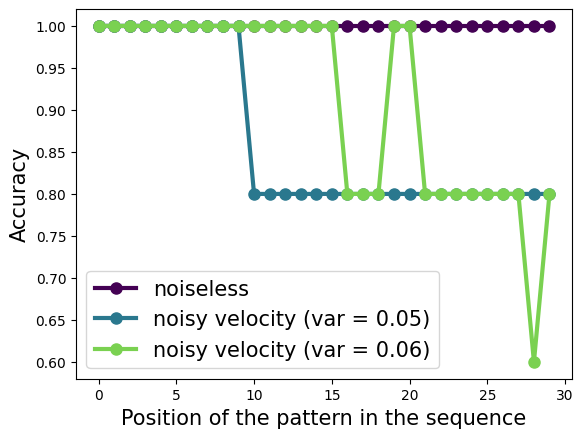

In [59]:
cmap_name = 'viridis'
cm = pl.get_cmap(cmap_name)


pl.plot(np.arange(sequence_length), np.mean(
    accs[0, :, :], axis=0), label='noiseless', c=cm(0), linewidth=3, marker='o', markersize=8)


pl.plot(np.mean(accs[1, :, :], axis=0), label='noisy velocity (var = 0.05)', c=cm(
    0.4), linewidth=3, marker='o', markersize=8)

pl.plot(np.mean(accs[2, :, :], axis=0), label='noisy velocity (var = 0.06)', c=cm(
    0.8), linewidth=3, marker='o', markersize=8)

pl.xlabel('Position of the pattern in the sequence', fontsize=15)
pl.ylabel('Accuracy', fontsize=15)
pl.legend(prop={'size': 15})
